In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import os, time
import matplotlib.pyplot as plt

# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('COVID_dataset.csv')

In [ ]:
df.columns

Index(['Accurate_Episode_Date', 'Case_Reported_Date', 'Test_Reported_Date',
       'Specimen_Date', 'Age_Group', 'Client_Gender', 'Case_AcquisitionInfo',
       'Reporting_PHU_City', 'Outbreak_Related', 'Reporting_PHU_Latitude',
       'Reporting_PHU_Longitude', 'Outcome1'],
      dtype='object')

In [ ]:
df.head(5)

,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU_City,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Outcome1
0,3/30/2020,3/31/2020,3/31/2020,3/30/2020,70s,MALE,OB,Stratford,Yes,43.368662,-81.001913,Fatal
1,1/22/2021,1/24/2021,1/24/2021,1/23/2021,50s,FEMALE,NO KNOWN EPI LINK,Newmarket,NaN,44.048023,-79.480239,Not Resolved
2,3/24/2020,4/14/2020,4/14/2020,4/13/2020,70s,FEMALE,OB,Toronto,Yes,43.656591,-79.379358,Resolved
3,1/18/2021,1/21/2021,1/21/2021,1/18/2021,<20,MALE,CC,Mississauga,NaN,43.647471,-79.708893,Not Resolved
4,12/26/2020,12/28/2020,12/28/2020,12/26/2020,60s,MALE,OB,Windsor,Yes,42.308796,-83.033670,Resolved


In [ ]:
df.describe()

,Reporting_PHU_Latitude,Reporting_PHU_Longitude
count,14860.000000,14860.000000
mean,43.732581,-79.570565
std,0.743379,1.581528
min,42.308796,-94.488254
25%,43.524881,-79.708893
50%,43.656591,-79.480239
75%,43.656591,-79.379358
max,49.769615,-74.736298


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14860 entries, 0 to 14859
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Accurate_Episode_Date    14860 non-null  object 
 1   Case_Reported_Date       14860 non-null  object 
 2   Test_Reported_Date       14657 non-null  object 
 3   Specimen_Date            14738 non-null  object 
 4   Age_Group                14855 non-null  object 
 5   Client_Gender            14860 non-null  object 
 6   Case_AcquisitionInfo     14860 non-null  object 
 7   Reporting_PHU_City       14860 non-null  object 
 8   Outbreak_Related         5778 non-null   object 
 9   Reporting_PHU_Latitude   14860 non-null  float64
 10  Reporting_PHU_Longitude  14860 non-null  float64
 11  Outcome1                 14860 non-null  object 
dtypes: float64(2), object(10)
memory usage: 1.4+ MB


In [ ]:
df.dtypes

Accurate_Episode_Date       object
Case_Reported_Date          object
Test_Reported_Date          object
Specimen_Date               object
Age_Group                   object
Client_Gender               object
Case_AcquisitionInfo        object
Reporting_PHU_City          object
Outbreak_Related            object
Reporting_PHU_Latitude     float64
Reporting_PHU_Longitude    float64
Outcome1                    object
dtype: object

In [ ]:
df.isna().sum()

Accurate_Episode_Date         0
Case_Reported_Date            0
Test_Reported_Date          203
Specimen_Date               122
Age_Group                     5
Client_Gender                 0
Case_AcquisitionInfo          0
Reporting_PHU_City            0
Outbreak_Related           9082
Reporting_PHU_Latitude        0
Reporting_PHU_Longitude       0
Outcome1                      0
dtype: int64

In [ ]:
# Removing NAn values from age group and replacing in other features
df = df[df['Age_Group'].notna()]
df.loc[df['Test_Reported_Date'].isnull(),'Test_Reported_Date'] = df['Case_Reported_Date']
df.loc[df['Specimen_Date'].isnull(),'Specimen_Date'] = df['Accurate_Episode_Date']
df['Outbreak_Related'].fillna(value='No', inplace=True)

In [ ]:
df.isna().sum()

Accurate_Episode_Date      0
Case_Reported_Date         0
Test_Reported_Date         0
Specimen_Date              0
Age_Group                  0
Client_Gender              0
Case_AcquisitionInfo       0
Reporting_PHU_City         0
Outbreak_Related           0
Reporting_PHU_Latitude     0
Reporting_PHU_Longitude    0
Outcome1                   0
dtype: int64

In [ ]:
# one-hot encoding for categorical variables and ordinal encoding for age group column
cats = ['Client_Gender', 'Case_AcquisitionInfo', 'Outbreak_Related', 'Reporting_PHU_City']
df['Outcome1'].replace(['Resolved', 'Not Resolved', 'Fatal'],[0,1,2], inplace = True)
df['Age_Group'].replace(['<20', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s'], [19,20,30,40,50,60,70,80,90], inplace = True)
df_temp = pd.get_dummies(df.iloc[:,:-1], columns=cats, drop_first=True)
df_temp['Outcome1'] = df['Outcome1']
df = df_temp

In [ ]:
# converting date to integers  
for column in ('Accurate_Episode_Date', 'Case_Reported_Date', 'Test_Reported_Date', 'Specimen_Date'):
        df[column] = pd.to_datetime(df[column]).astype(int) // int(1e9)

In [ ]:
# scaling down numerical features
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

scaled_features = df.copy()
col_names = ['Accurate_Episode_Date', 'Case_Reported_Date', 'Test_Reported_Date', 
             'Specimen_Date', 'Reporting_PHU_Latitude', 'Reporting_PHU_Longitude']
features = scaled_features[col_names]
scaler = RobustScaler().fit(features.values)
# scaler = StandardScaler().fit(features.values)
# scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)

scaled_features[col_names] = features
df = scaled_features

In [ ]:
from sklearn.model_selection import train_test_split

# splitting data and target
X = df.drop(['Outcome1'], axis=1)
y = df['Outcome1']

# dividing the data into train, validation and test sets (80%, 10%, 10%) with random_state=0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

## MODEL - DNN

In [ ]:
# Model
EPOCHS = 50
BATCH_SIZE = 64

In [ ]:
# Dependencies
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import activations
from tensorflow.keras.optimizers import Adam, SGD

# Deep Neural network
model = Sequential()
model.add(Dense(32, activation=activations.relu))
model.add(Dense(32, activation=activations.relu))
model.add(Dense(32, activation=activations.relu))
model.add(Dense(16, activation=activations.relu))
model.add(Dense(3, activation=activations.softmax))

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
# Train the the model
start_time = time.time()
train_model = model.fit(X_train, y_train, batch_size=BATCH_SIZE, 
                        epochs=EPOCHS, verbose=1, validation_data=(X_val, y_val),
                        shuffle=True)
end_time = time.time()
print("Total training time : {:0.2f} minute".format((end_time - start_time)/60.0))

Epoch 1/50
186/186 [==============================] - 1s 5ms/step - loss: 1.3667 - accuracy: 0.4522 - val_loss: 0.5919 - val_accuracy: 0.7604
Epoch 2/50
186/186 [==============================] - 0s 2ms/step - loss: 0.5247 - accuracy: 0.7961 - val_loss: 0.3649 - val_accuracy: 0.8742
Epoch 3/50
186/186 [==============================] - 0s 2ms/step - loss: 0.3571 - accuracy: 0.8725 - val_loss: 0.3347 - val_accuracy: 0.8869
Epoch 4/50
186/186 [==============================] - 0s 2ms/step - loss: 0.3245 - accuracy: 0.8855 - val_loss: 0.3197 - val_accuracy: 0.8836
Epoch 5/50
186/186 [==============================] - 0s 2ms/step - loss: 0.3056 - accuracy: 0.8845 - val_loss: 0.3421 - val_accuracy: 0.8701
Epoch 6/50
186/186 [==============================] - 0s 2ms/step - loss: 0.2993 - accuracy: 0.8861 - val_loss: 0.4053 - val_accuracy: 0.8627
Epoch 7/50
186/186 [==============================] - 0s 2ms/step - loss: 0.2988 - accuracy: 0.8926 - val_loss: 0.3057 - val_accuracy: 0.8923
Epoch 

In [ ]:
score = model.evaluate(X_train, y_train, verbose=0)
print('Train accuracy:', score[1])
print('Train loss:', score[0])

Train accuracy: 0.916610598564148
Train loss: 0.23439332842826843


In [ ]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Val accuracy:', score[1])
print('Val loss:', score[0])

Train accuracy: 0.9098250269889832
Train loss: 0.2454405128955841


In [ ]:
%%time
y_pred = np.argmax(model.predict(X_test), axis=-1)

CPU times: user 222 ms, sys: 6.47 ms, total: 228 ms
Wall time: 224 ms


In [ ]:
%%time
score = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score[1])
print('Test loss:', score[0])

Test accuracy: 0.9178451299667358
Test loss: 0.2335989624261856
CPU times: user 150 ms, sys: 9.7 ms, total: 160 ms
Wall time: 150 ms


In [ ]:
def accuracy_loss_plot(model):

  hist = model.history
  acc = hist['accuracy']
  val_acc = hist['val_accuracy']
  loss = hist['loss']
  val_loss = hist['val_loss']
  epoch = range(50)

  fig = plt.figure(figsize = (12,10))
  plt.subplot(2,2,1)
  sns.lineplot(acc,loss)
  plt.xlabel('Accuracy')
  plt.ylabel('Loss')
  plt.legend(['train set'], loc='upper right')
  plt.title('Training Accuracy vs Loss')

  plt.subplot(2,2,2)
  sns.lineplot(val_acc,val_loss)
  plt.xlabel('Accuracy')
  plt.ylabel('Loss')
  plt.legend(['validation set'], loc='upper right')
  plt.title('Validation Accuracy vs Loss')

  plt.subplot(2,2,3)
  sns.lineplot(epoch, acc)
  sns.lineplot(epoch, val_acc)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['train set', 'validation set'], loc='lower right')
  plt.title('Accuracy vs Epoch')

  plt.subplot(2,2,4)
  sns.lineplot(epoch, loss)
  sns.lineplot(epoch, val_loss)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['train set', 'validation set'], loc='upper right')
  plt.title('Loss vs Epoch')

  plt.show()

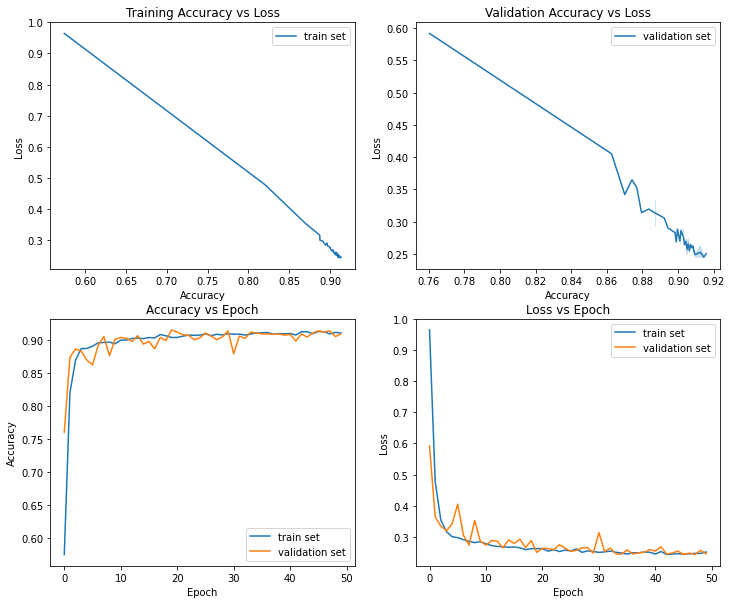

In [ ]:
accuracy_loss_plot(train_model)

In [ ]:
# y_test1 = np.argmax(y_test, axis=-1)

In [ ]:
from sklearn.metrics import classification_report

target_names = [" {}:".format(i)  for i in ['Resolved', 'Not Resolved', 'Fatal']]
print(classification_report(y_pred, y_test, target_names=target_names))

                precision    recall  f1-score   support

     Resolved:       0.86      0.94      0.90       450
 Not Resolved:       0.97      0.95      0.96       502
        Fatal:       0.93      0.87      0.90       533

      accuracy                           0.92      1485
     macro avg       0.92      0.92      0.92      1485
  weighted avg       0.92      0.92      0.92      1485



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                1600      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 51        
Total params: 4,291
Trainable params: 4,291
Non-trainable params: 0
_________________________________________________________________


## MODEL1 - DNN (DEEPER- MORE HIDDEN LAYERS)

In [ ]:
# Deep Neural network
model1 = Sequential()
model1.add(Dense(32, activation=activations.relu))
model1.add(Dense(32, activation=activations.relu))
model1.add(Dense(32, activation=activations.relu))
model1.add(Dense(32, activation=activations.relu))
model1.add(Dense(32, activation=activations.relu))
model1.add(Dense(16, activation=activations.relu))
model1.add(Dense(3, activation=activations.softmax))

model1.compile(loss='sparse_categorical_crossentropy',
               optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
# Train the the model
start_time = time.time()
train_model1 = model1.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_data=(X_val, y_val), shuffle=True)
end_time = time.time()
print("Total training time : {:0.2f} minute".format((end_time - start_time)/60.0))

Epoch 1/50
186/186 [==============================] - 1s 3ms/step - loss: 1.0153 - accuracy: 0.4326 - val_loss: 0.5063 - val_accuracy: 0.8035
Epoch 2/50
186/186 [==============================] - 0s 2ms/step - loss: 0.4430 - accuracy: 0.8338 - val_loss: 0.3370 - val_accuracy: 0.8903
Epoch 3/50
186/186 [==============================] - 0s 2ms/step - loss: 0.3425 - accuracy: 0.8741 - val_loss: 0.3103 - val_accuracy: 0.8876
Epoch 4/50
186/186 [==============================] - 0s 2ms/step - loss: 0.3237 - accuracy: 0.8788 - val_loss: 0.2918 - val_accuracy: 0.8984
Epoch 5/50
186/186 [==============================] - 0s 2ms/step - loss: 0.2942 - accuracy: 0.8912 - val_loss: 0.3177 - val_accuracy: 0.8856
Epoch 6/50
186/186 [==============================] - 0s 2ms/step - loss: 0.3054 - accuracy: 0.8893 - val_loss: 0.2753 - val_accuracy: 0.9105
Epoch 7/50
186/186 [==============================] - 0s 2ms/step - loss: 0.2760 - accuracy: 0.8990 - val_loss: 0.2721 - val_accuracy: 0.9011
Epoch 

In [ ]:
score = model1.evaluate(X_train, y_train, verbose=0)
print('Train accuracy:', score[1])
print('Train loss:', score[0])

Train accuracy: 0.9059239029884338
Train loss: 0.27192944288253784


In [ ]:
score = model1.evaluate(X_val, y_val, verbose=0)
print('Val accuracy:', score[1])
print('Val loss:', score[0])

Train accuracy: 0.8963660597801208
Train loss: 0.28734299540519714


In [ ]:
%%time
y_pred = np.argmax(model1.predict(X_test), axis=-1)

CPU times: user 181 ms, sys: 6.9 ms, total: 188 ms
Wall time: 184 ms


In [ ]:
%%time
score = model1.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score[1])
print('Test loss:', score[0])

Test accuracy: 0.9043771028518677
Test loss: 0.27723628282546997
CPU times: user 155 ms, sys: 8.67 ms, total: 163 ms
Wall time: 162 ms


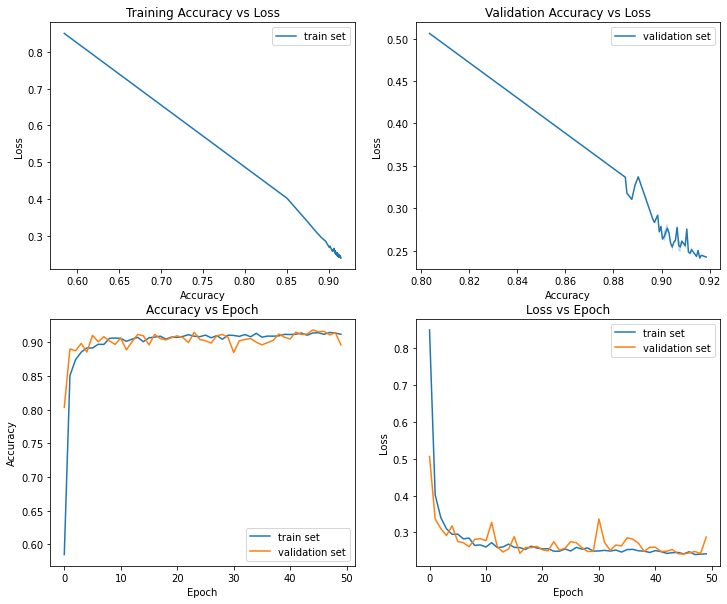

In [ ]:
accuracy_loss_plot(train_model1)

In [ ]:
# y_test2 = np.argmax(y_test, axis=-1)

In [ ]:
from sklearn.metrics import classification_report

target_names = [" {}:".format(i)  for i in ['Resolved', 'Not Resolved', 'Fatal']]
print(classification_report(y_pred, y_test, target_names=target_names))

                precision    recall  f1-score   support

     Resolved:       0.84      0.93      0.88       442
 Not Resolved:       0.99      0.89      0.93       553
        Fatal:       0.89      0.90      0.89       490

      accuracy                           0.90      1485
     macro avg       0.90      0.91      0.90      1485
  weighted avg       0.91      0.90      0.91      1485



In [ ]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                1600      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_11 (Dense)             (None, 3)                

## Model2 - DROPOUT & BATCH NORMALIZATION

In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

# Model
model2 = Sequential()
model2.add(Dense(32, activation=activations.relu))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(Dense(32, activation=activations.relu))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))
model2.add(Dense(32, activation=activations.relu))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))
model2.add(Dense(16, activation=activations.relu))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(Dense(3, activation=activations.softmax))

model2.compile(loss='sparse_categorical_crossentropy',
               optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
# Train the the model
start_time = time.time()
train_model2 = model2.fit(X_train, y_train, batch_size=BATCH_SIZE, 
                          epochs=EPOCHS, verbose=1, validation_data=(X_val, y_val),
                          shuffle=True)
end_time = time.time()
print("Total training time : {:0.2f} minute".format((end_time - start_time)/60.0))

Epoch 1/50
186/186 [==============================] - 2s 5ms/step - loss: 1.0772 - accuracy: 0.5058 - val_loss: 0.7862 - val_accuracy: 0.6783
Epoch 2/50
186/186 [==============================] - 1s 3ms/step - loss: 0.7568 - accuracy: 0.6562 - val_loss: 0.5043 - val_accuracy: 0.8190
Epoch 3/50
186/186 [==============================] - 1s 3ms/step - loss: 0.5590 - accuracy: 0.7929 - val_loss: 0.3283 - val_accuracy: 0.8950
Epoch 4/50
186/186 [==============================] - 1s 3ms/step - loss: 0.4678 - accuracy: 0.8296 - val_loss: 0.2882 - val_accuracy: 0.8997
Epoch 5/50
186/186 [==============================] - 1s 3ms/step - loss: 0.4322 - accuracy: 0.8419 - val_loss: 0.2776 - val_accuracy: 0.9051
Epoch 6/50
186/186 [==============================] - 1s 3ms/step - loss: 0.3892 - accuracy: 0.8669 - val_loss: 0.2786 - val_accuracy: 0.9024
Epoch 7/50
186/186 [==============================] - 1s 3ms/step - loss: 0.3727 - accuracy: 0.8705 - val_loss: 0.2654 - val_accuracy: 0.9044
Epoch 

In [ ]:
score = model2.evaluate(X_train, y_train, verbose=0)
print('Train accuracy:', score[1])
print('Train loss:', score[0])

Train accuracy: 0.9116458892822266
Train loss: 0.24532747268676758


In [ ]:
score = model2.evaluate(X_val, y_val, verbose=0)
print('Val accuracy:', score[1])
print('Val loss:', score[0])

Train accuracy: 0.9118438959121704
Train loss: 0.24480681121349335


In [ ]:
%%time
y_pred = np.argmax(model2.predict(X_test), axis=-1)

CPU times: user 304 ms, sys: 8.16 ms, total: 313 ms
Wall time: 301 ms


In [ ]:
%%time
score = model2.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score[1])
print('Test loss:', score[0])

Test accuracy: 0.9191918969154358
Test loss: 0.23249362409114838
CPU times: user 153 ms, sys: 1.74 ms, total: 154 ms
Wall time: 141 ms


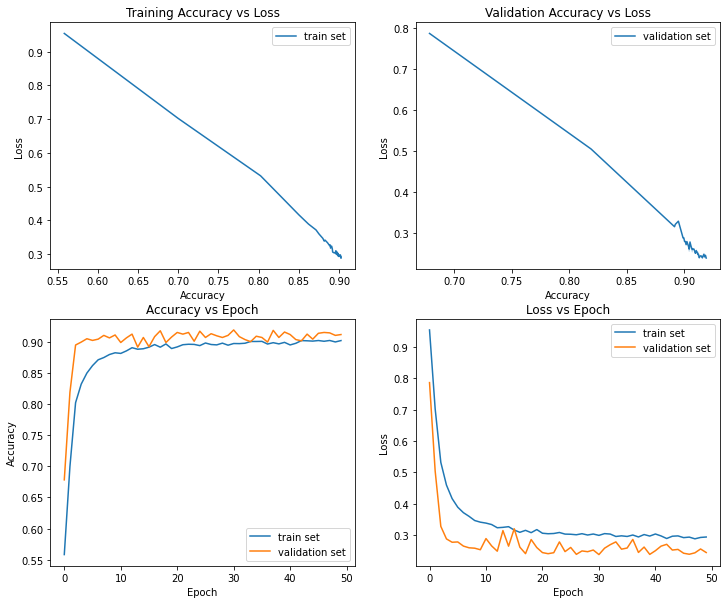

In [ ]:
accuracy_loss_plot(train_model2)

In [ ]:
# y_test3 = np.argmax(y_test, axis=-1)

In [ ]:
from sklearn.metrics import classification_report

target_names = [" {}:".format(i)  for i in ['Resolved', 'Not Resolved', 'Fatal']]
print(classification_report(y_pred, y_test, target_names=target_names))

                precision    recall  f1-score   support

     Resolved:       0.86      0.94      0.90       451
 Not Resolved:       0.97      0.96      0.96       504
        Fatal:       0.93      0.87      0.90       530

      accuracy                           0.92      1485
     macro avg       0.92      0.92      0.92      1485
  weighted avg       0.92      0.92      0.92      1485



In [ ]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                1600      
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                1056      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)               

## Model3 - Simple RNN 

In [ ]:
# Reshaping X_train, X_val and X_test for efficient modelling
X_train = np.expand_dims(X_train, 1)
X_val = np.expand_dims(X_val, 1)
X_test = np.expand_dims(X_test, 1)

In [ ]:
from tensorflow.keras.layers import SimpleRNN

# Recurrent Neural network
model3 = Sequential()

# First SimpleRNN layer 
model3.add(SimpleRNN(32, return_sequences=True, activation=activations.tanh, 
                     use_bias=True))
model3.add(Dropout(0.2))
model3.add(BatchNormalization())
# Second SimpleRNN layer
model3.add(SimpleRNN(32, return_sequences=True, activation=activations.tanh))
model3.add(Dropout(0.3))
model3.add(BatchNormalization())
# Third SimpleRNN layer
model3.add(SimpleRNN(32, return_sequences=True, activation=activations.tanh))
model3.add(Dropout(0.3))
model3.add(BatchNormalization())
# Fourth SimpleRNN layer
model3.add(SimpleRNN(16, activation=activations.tanh))
model3.add(Dropout(0.2))
model3.add(BatchNormalization())
# The output layer
model3.add(Dense(3, activation=activations.softmax))

model3.compile(loss='sparse_categorical_crossentropy',
               optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
# Train the the model
start_time = time.time()
train_model3 = model3.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_data=(X_val, y_val), shuffle=True)
end_time = time.time()
print("Total training time : {:0.2f} minute".format((end_time - start_time)/60.0))

Epoch 1/50
186/186 [==============================] - 6s 8ms/step - loss: 1.1914 - accuracy: 0.4143 - val_loss: 0.6388 - val_accuracy: 0.7194
Epoch 2/50
186/186 [==============================] - 1s 5ms/step - loss: 0.7689 - accuracy: 0.6533 - val_loss: 0.5390 - val_accuracy: 0.7779
Epoch 3/50
186/186 [==============================] - 1s 5ms/step - loss: 0.5997 - accuracy: 0.7473 - val_loss: 0.3965 - val_accuracy: 0.8499
Epoch 4/50
186/186 [==============================] - 1s 5ms/step - loss: 0.5057 - accuracy: 0.8019 - val_loss: 0.3626 - val_accuracy: 0.8755
Epoch 5/50
186/186 [==============================] - 1s 5ms/step - loss: 0.4609 - accuracy: 0.8272 - val_loss: 0.3072 - val_accuracy: 0.8964
Epoch 6/50
186/186 [==============================] - 1s 5ms/step - loss: 0.4358 - accuracy: 0.8352 - val_loss: 0.2982 - val_accuracy: 0.8984
Epoch 7/50
186/186 [==============================] - 1s 5ms/step - loss: 0.3949 - accuracy: 0.8582 - val_loss: 0.3046 - val_accuracy: 0.8977
Epoch 

In [ ]:
score = model3.evaluate(X_train, y_train, verbose=0)
print('Train accuracy:', score[1])
print('Train loss:', score[0])

Train accuracy: 0.9121508002281189
Train loss: 0.24968016147613525


In [ ]:
score = model3.evaluate(X_val, y_val, verbose=0)
print('Val accuracy:', score[1])
print('Val loss:', score[0])

Train accuracy: 0.914535641670227
Train loss: 0.2510635256767273


In [ ]:
%%time
y_pred = np.argmax(model3.predict(X_test), axis=-1)

CPU times: user 633 ms, sys: 6.93 ms, total: 640 ms
Wall time: 614 ms


In [ ]:
%%time
score = model3.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score[1])
print('Test loss:', score[0])

Train accuracy: 0.9138047099113464
Train loss: 0.24396991729736328
CPU times: user 138 ms, sys: 5.41 ms, total: 144 ms
Wall time: 115 ms


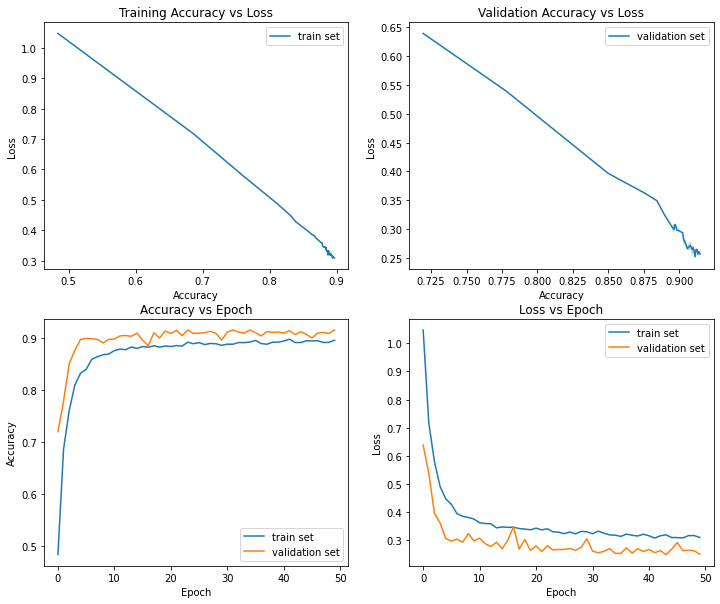

In [ ]:
accuracy_loss_plot(train_model3)

In [ ]:
# y_test4 = np.argmax(y_test, axis=-1)

In [ ]:
from sklearn.metrics import classification_report

target_names = [" {}:".format(i)  for i in ['Resolved', 'Not Resolved', 'Fatal']]
print(classification_report(y_pred, y_test, target_names=target_names))

                precision    recall  f1-score   support

     Resolved:       0.88      0.90      0.89       482
 Not Resolved:       0.96      0.96      0.96       494
        Fatal:       0.90      0.88      0.89       509

      accuracy                           0.91      1485
     macro avg       0.91      0.91      0.91      1485
  weighted avg       0.91      0.91      0.91      1485



In [ ]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1, 32)             2624      
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1, 32)             128       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 1, 32)             2080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 1, 32)             128       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 1, 32)            

## Model4 - LSTM

In [ ]:
from tensorflow.keras.layers import LSTM

# Recurrent Neural network - LSTM
model4 = Sequential()

# First LSTM layer with Dropout regularisation
model4.add(LSTM(32, return_sequences=True, activation=activations.tanh))
model4.add(Dropout(0.2))
model4.add(BatchNormalization())
# Second LSTM layer
model4.add(LSTM(32, return_sequences=True, activation=activations.tanh))
model4.add(Dropout(0.3))
model4.add(BatchNormalization())
# Third LSTM layer
model4.add(LSTM(32, return_sequences=True, activation=activations.tanh))
model4.add(Dropout(0.3))
model4.add(BatchNormalization())
# Fourth LSTM layer
model4.add(LSTM(16, activation=activations.tanh))
model4.add(Dropout(0.2))
model4.add(BatchNormalization())
# The output layer
model4.add(Dense(3, activation=activations.softmax))

model4.compile(loss='sparse_categorical_crossentropy',
               optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
# Train the the model
start_time = time.time()
train_model4 = model4.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_data=(X_val, y_val), shuffle=True)
end_time = time.time()
print("Total training time : {:0.2f} minute".format((end_time - start_time)/60.0))

Epoch 1/50
186/186 [==============================] - 12s 18ms/step - loss: 1.0708 - accuracy: 0.5069 - val_loss: 1.0591 - val_accuracy: 0.3378
Epoch 2/50
186/186 [==============================] - 1s 8ms/step - loss: 0.6202 - accuracy: 0.7467 - val_loss: 0.5205 - val_accuracy: 0.8398
Epoch 3/50
186/186 [==============================] - 1s 8ms/step - loss: 0.4602 - accuracy: 0.8329 - val_loss: 0.3126 - val_accuracy: 0.8910
Epoch 4/50
186/186 [==============================] - 1s 8ms/step - loss: 0.4009 - accuracy: 0.8539 - val_loss: 0.2637 - val_accuracy: 0.9038
Epoch 5/50
186/186 [==============================] - 1s 8ms/step - loss: 0.3789 - accuracy: 0.8633 - val_loss: 0.2835 - val_accuracy: 0.8991
Epoch 6/50
186/186 [==============================] - 1s 8ms/step - loss: 0.3717 - accuracy: 0.8631 - val_loss: 0.2884 - val_accuracy: 0.9004
Epoch 7/50
186/186 [==============================] - 1s 8ms/step - loss: 0.3564 - accuracy: 0.8747 - val_loss: 0.2939 - val_accuracy: 0.8984
Epoc

In [ ]:
score = model4.evaluate(X_train, y_train, verbose=0)
print('Train accuracy:', score[1])
print('Train loss:', score[0])

Train accuracy: 0.9170312881469727
Train loss: 0.23400264978408813


In [ ]:
score = model4.evaluate(X_val, y_val, verbose=0)
print('Val accuracy:', score[1])
print('Val loss:', score[0])

Train accuracy: 0.9071332216262817
Train loss: 0.24606677889823914


In [ ]:
%%time
y_pred = np.argmax(model4.predict(X_test), axis=-1)

CPU times: user 1.7 s, sys: 43 ms, total: 1.75 s
Wall time: 1.7 s


In [ ]:
%%time
score = model4.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score[1])
print('Test loss:', score[0])

Test accuracy: 0.9191918969154358
Test loss: 0.24080206453800201
CPU times: user 155 ms, sys: 14.1 ms, total: 169 ms
Wall time: 125 ms


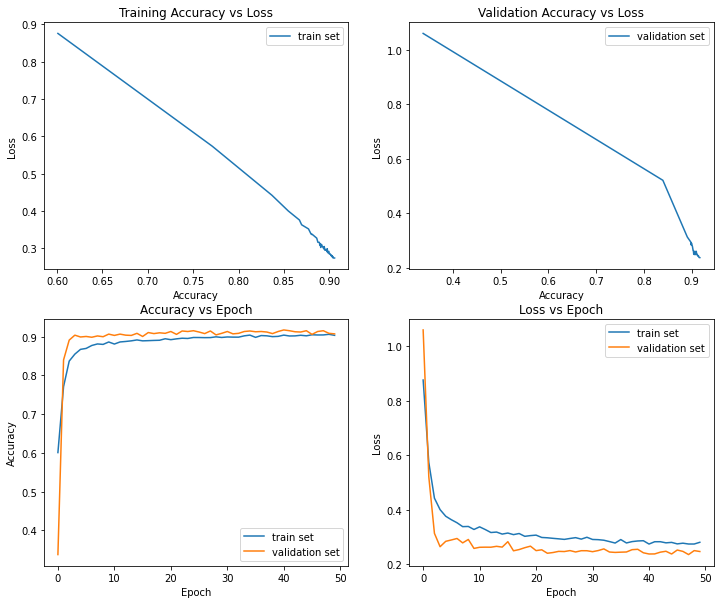

In [ ]:
accuracy_loss_plot(train_model4)

In [ ]:
# y_test5 = np.argmax(y_test, axis=-1)

In [ ]:
from sklearn.metrics import classification_report

target_names = [" {}:".format(i)  for i in ['Resolved', 'Not Resolved', 'Fatal']]
print(classification_report(y_pred, y_test, target_names=target_names))

                precision    recall  f1-score   support

     Resolved:       0.88      0.92      0.90       475
 Not Resolved:       0.95      0.97      0.96       484
        Fatal:       0.93      0.87      0.90       526

      accuracy                           0.92      1485
     macro avg       0.92      0.92      0.92      1485
  weighted avg       0.92      0.92      0.92      1485



In [ ]:
model4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 32)             10496     
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 1, 32)             128       
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 32)             8320      
_________________________________________________________________
dropout_9 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 1, 32)             128       
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 32)            